In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
import time
import datetime 
%matplotlib inline  
import sys
sys.path.append('/gpfs2/projects/project-bus_capstone_2016/workspace/jz2308/bus-Capstone')

# these two modules are homemade
import gtfs
import arrivals
import ttools
os.chdir('/gpfs2/projects/project-bus_capstone_2016/workspace/share')

In [2]:
base = datetime.date(2015, 1, 1)
schedule_samples = [str(base + datetime.timedelta(days=x)) for x in range(0, 365)]
#schedule_samples = ['2015-01-04','2015-04-05','2015-06-27','2015-07-06','2015-09-05','2015-09-15','2015-10-12']
collected = pd.DataFrame()
for sdate in schedule_samples:
    stops = gtfs.load_stops(sdate,'gtfs/')
    stops['schedule_sample_date'] = sdate
    collected = collected.append(stops[['stop_lat','stop_lon','stop_name','schedule_sample_date']].drop_duplicates())

In [3]:
collected.tail()

,stop_lat,stop_lon,stop_name,schedule_sample_date
stop_id,,,,
985005,40.933637,-73.897818,S BROADWAY/NEW MAIN ST,2015-12-31
985006,40.932045,-73.899141,S BROADWAY/PROSPECT AV,2015-12-31
985007,40.920549,-73.896247,S BROADWAY/McLEAN AV,2015-12-31
985008,40.928762,-73.896532,S BROADWAY/VARK ST,2015-12-31
985009,40.917289,-73.896847,S BROADWAY/RADFORD ST,2015-12-31


In [4]:
reliability_metrics = pd.read_csv('performance.csv',names = ["Line", "stop_id", "schedule_sample_date", "ontime_ratio", "peak_hours wait ass","offpeak hours wait ass"])

In [11]:
collected.reset_index().head()

,stop_id,stop_lat,stop_lon,stop_name,schedule_sample_date
0,300000,40.578209,-73.939697,ORIENTAL BL/MACKENZIE ST,2015-01-01
1,300002,40.578068,-73.943031,ORIENTAL BL/JAFFRAY ST,2015-01-01
2,300003,40.577961,-73.944664,ORIENTAL BL/HASTINGS ST,2015-01-01
3,300004,40.577721,-73.946205,ORIENTAL BL/FALMOUTH ST,2015-01-01
4,300006,40.577354,-73.949554,ORIENTAL BL/DOVER ST,2015-01-01


In [17]:
pd.DataFrame(reliability_metrics.groupby('stop_id').mean().reset_index()).head()

,stop_id,ontime_ratio,offpeak hours wait ass
0,100014,0.139963,0.921871
1,100017,0.210164,0.913365
2,100018,0.177457,0.892479
3,100019,0.203798,0.918004
4,100020,0.203381,0.854682


In [22]:
stops_metrics = collected.reset_index().merge(pd.DataFrame(reliability_metrics.groupby('stop_id').mean().reset_index()))
stops_metrics = stops_metrics.groupby('stop_id').mean()[['stop_lat','stop_lon','ontime_ratio','offpeak hours wait ass']]

In [ ]:
#line_metrics = collected.reset_index().merge(pd.DataFrame(reliability_metrics.groupby('Line').mean()).reset_index())
#line_metrics.groupby('Line').mean()

In [24]:
stops_metrics.head()

,stop_lat,stop_lon,ontime_ratio,offpeak hours wait ass
stop_id,,,,
100014,40.872562,-73.888153,0.139963,0.921871
100017,40.876808,-73.889656,0.210164,0.913365
100018,40.880341,-73.886063,0.177457,0.892479
100019,40.813496,-73.929489,0.203798,0.918004
100020,40.816803,-73.927956,0.203381,0.854682


In [25]:
stops_metrics.to_csv('metrics-by-stop-2015.csv')

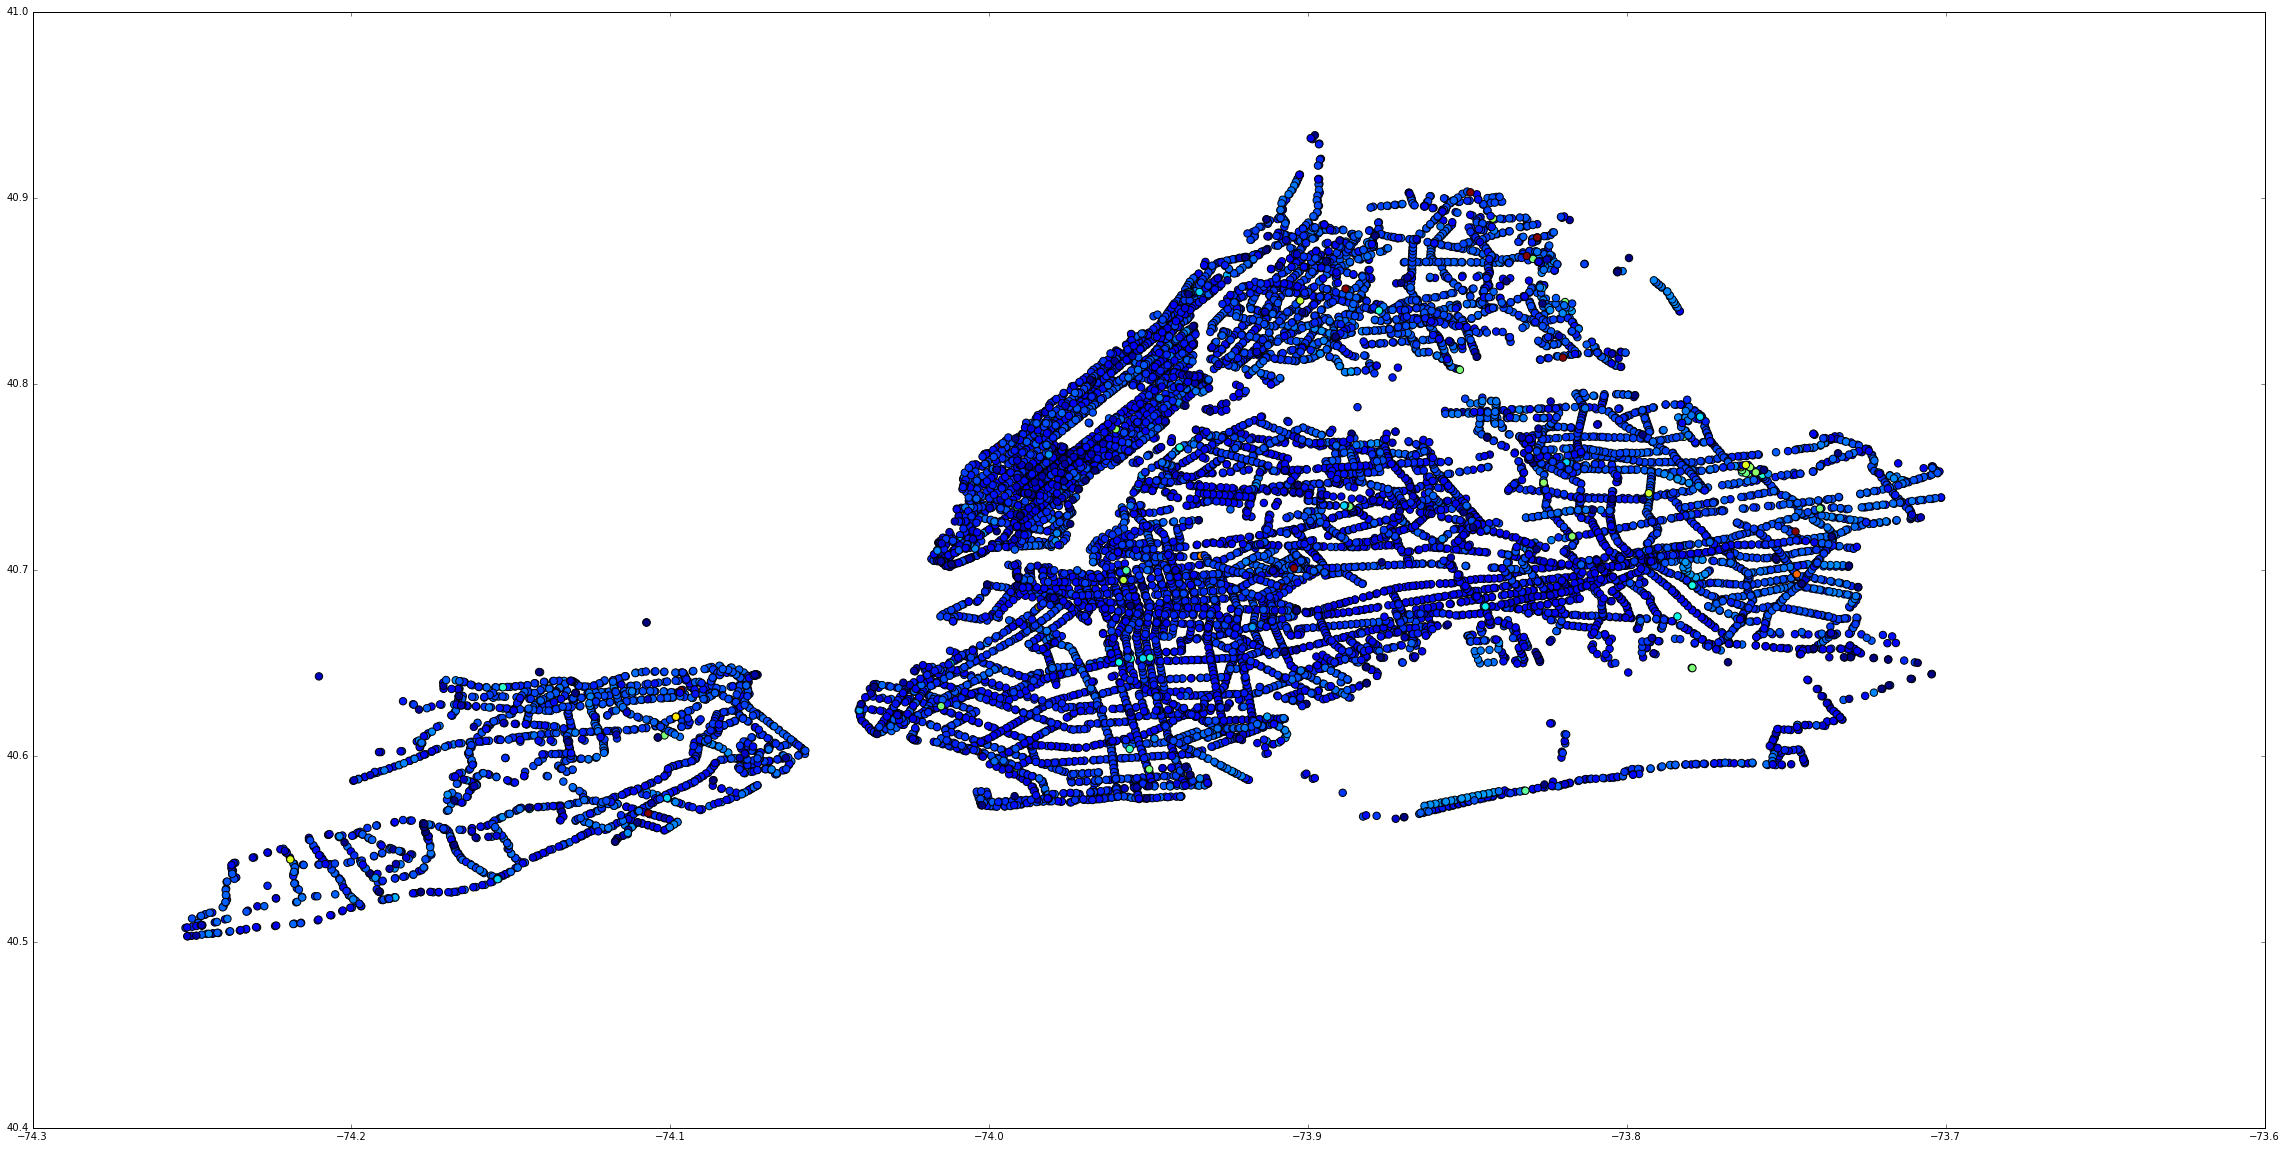

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(40,20))
plt.scatter(stops_metrics.stop_lon,stops_metrics.stop_lat,c=stops_metrics.ontime_ratio,s=55)
